In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Identifying a stationary ARMA process

In [2]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

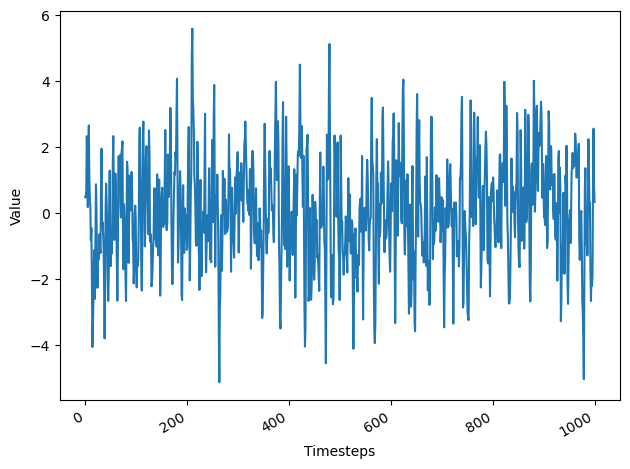

In [3]:
fig, ax = plt.subplots()

ax.plot(ARMA_1_1)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042671
p-value: 1.7078466680098608e-08


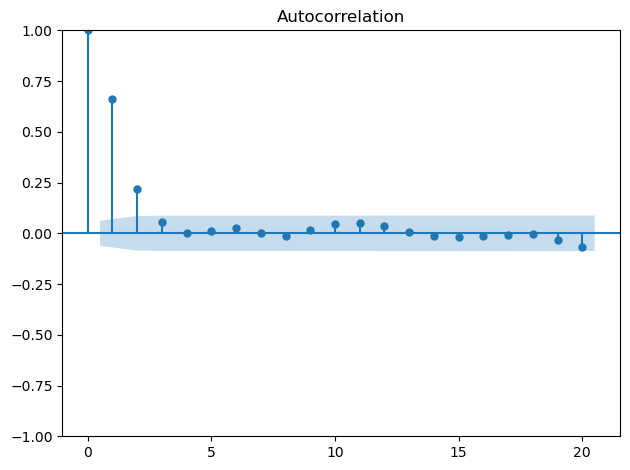

In [5]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()

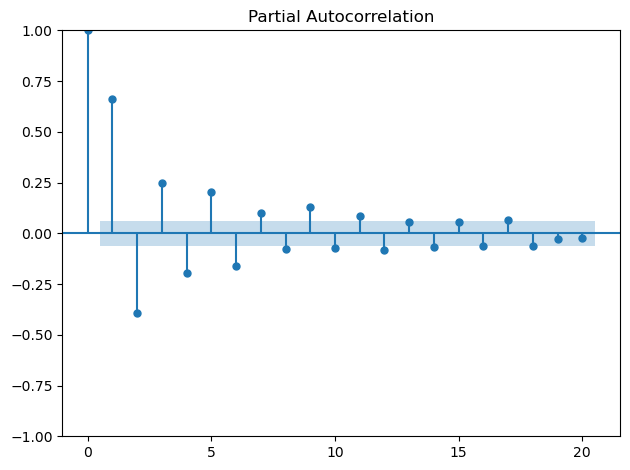

In [6]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()

##  Selecting the best model

In [7]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [9]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

# The model with the lowest AIC corresponds to an ARMA(1,1) model, which is exactly the process that we simulated.
# ARMA(1,1) model is the best model relative to all other models that we fit to our data.

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.987294
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


## Performing residuals analysis

### Qualitative analysis: studying the Q-Q plot

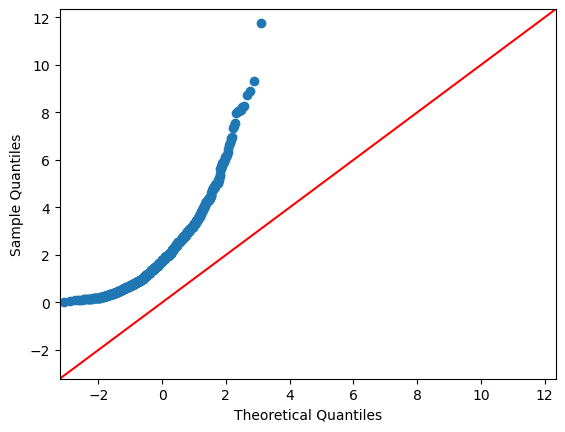

In [14]:
# The residuals of a model are simply the difference between the predicted values and the actual values.

# in a perfect situation the residuals of a model are
# white noise. This indicates that the model has captured all predictive information,
# and there is only a random fluctuation left that cannot be modeled.

# The residuals must be uncorrelated and have a normal distribution in order for us to conclude
# that we have a good model for making forecasts.
from statsmodels.graphics.gofplots import qqplot
#  quantile-quantile plot (Q-Q plot)

# plotting the quantiles of our residuals on the y-axis
# against the quantiles of a theoretical distribution, in this case the normal distribution,
# on the x-axis. This results in a scatterplot. We are comparing the distribution to 
# a normal distribution because we want the residuals to be similar to white noise, which is
# normally distributed.

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)
# A Q-Q plot of residuals that are not close to a normal distribution will generate a curve that departs from y = x.
qqplot(gamma, line='45');

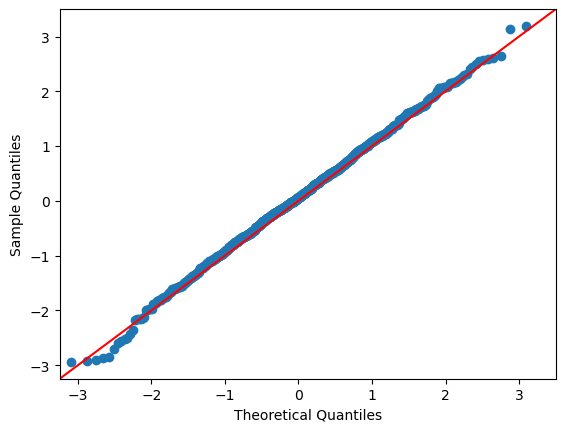

In [15]:
normal = np.random.normal(size=1000)
# An example of a Q-Q plot where the residuals are normally distributed
qqplot(normal, line='45');

## Performing residuals analysis

In [16]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

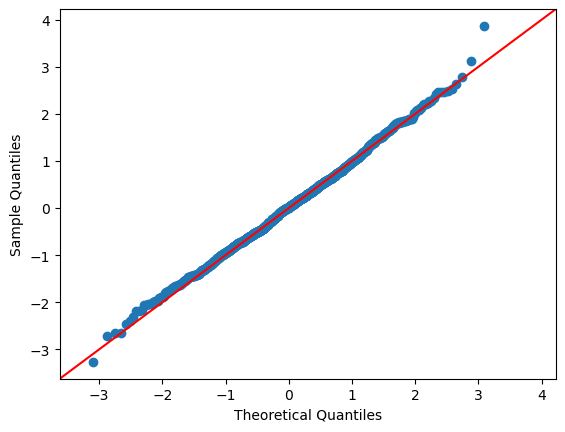

In [17]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

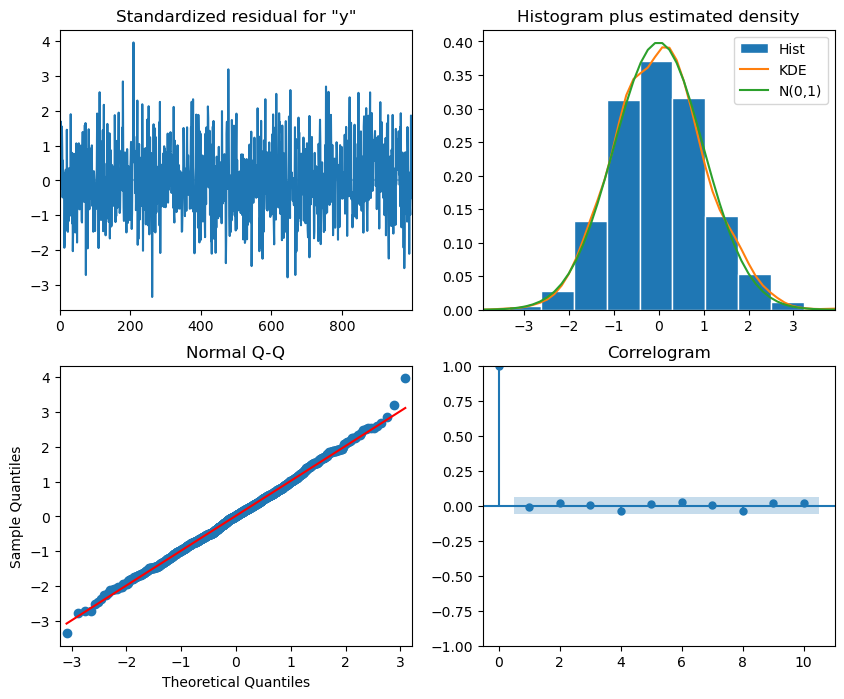

In [18]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [30]:
# Ljung-Box test
# This allows us to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get the full results DataFrame
lb_results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))
# input the residuals as well as a list of lags.

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

# The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, 
# the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

LB Statistics:
1     0.030706
2     0.528021
3     0.540904
4     2.079774
5     2.271897
6     2.896262
7     2.900378
8     4.418799
9     4.787567
10    5.246805
Name: lb_stat, dtype: float64

P-values:
1     0.860897
2     0.767966
3     0.909817
4     0.721089
5     0.810385
6     0.821750
7     0.894063
8     0.817501
9     0.852419
10    0.874093
Name: lb_pvalue, dtype: float64


# Applying the general modeling procedure

In [31]:
import pandas as pd

df = pd.read_csv('Data/bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


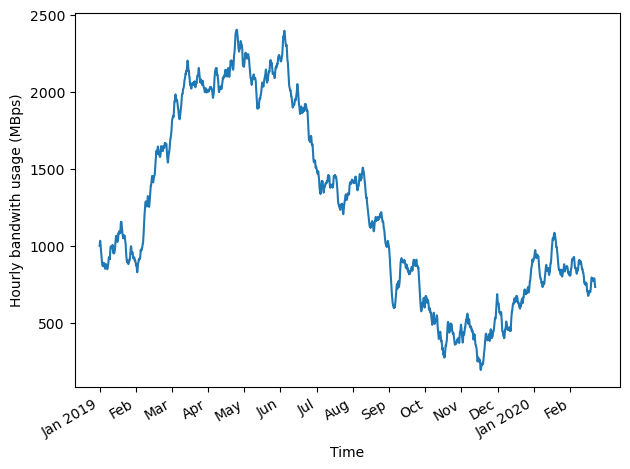

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# This prints out an ADF statistic of –0.8 and a p-value of 0.80. Therefore, we cannot
# reject the null hypothesis, meaning that our time series is not stationary. 

ADF Statistic: -0.871465319945218
p-value: 0.7972240255014729


In [34]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

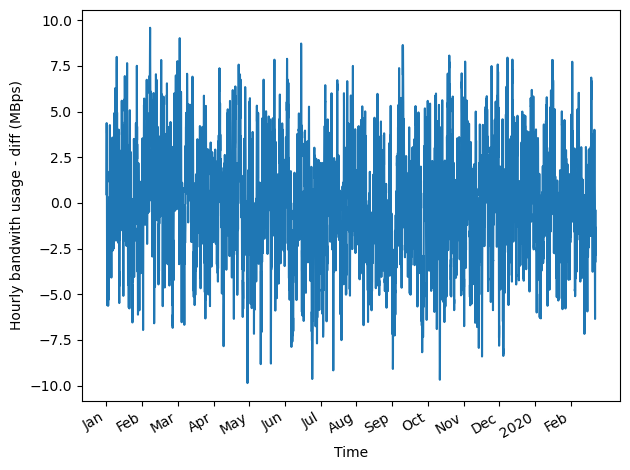

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [36]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.69485386378905
p-value: 0.0


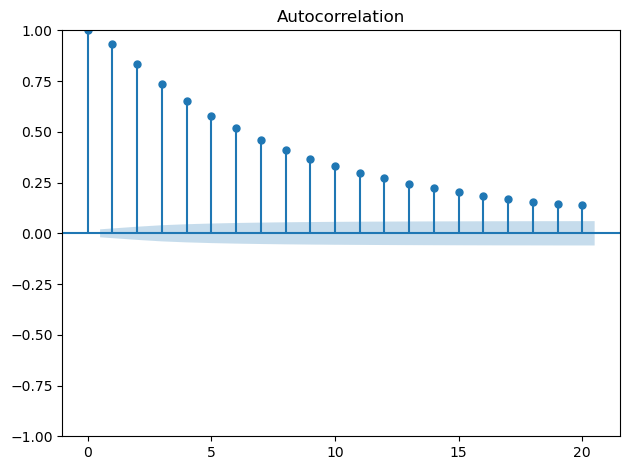

In [37]:
plot_acf(bandwidth_diff, lags=20);

plt.tight_layout()

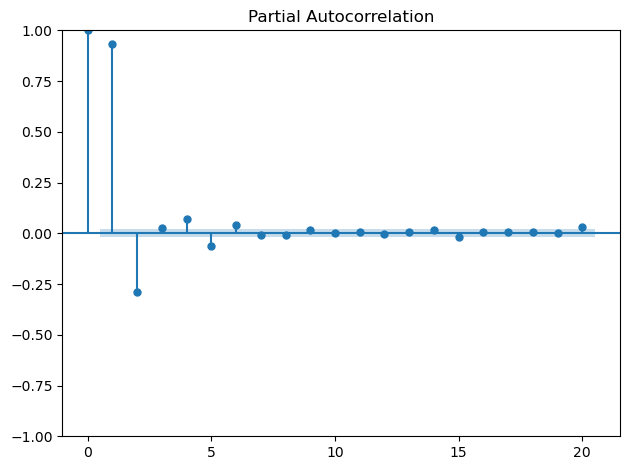

In [38]:
plot_pacf(bandwidth_diff, lags=20);

plt.tight_layout()

In [39]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


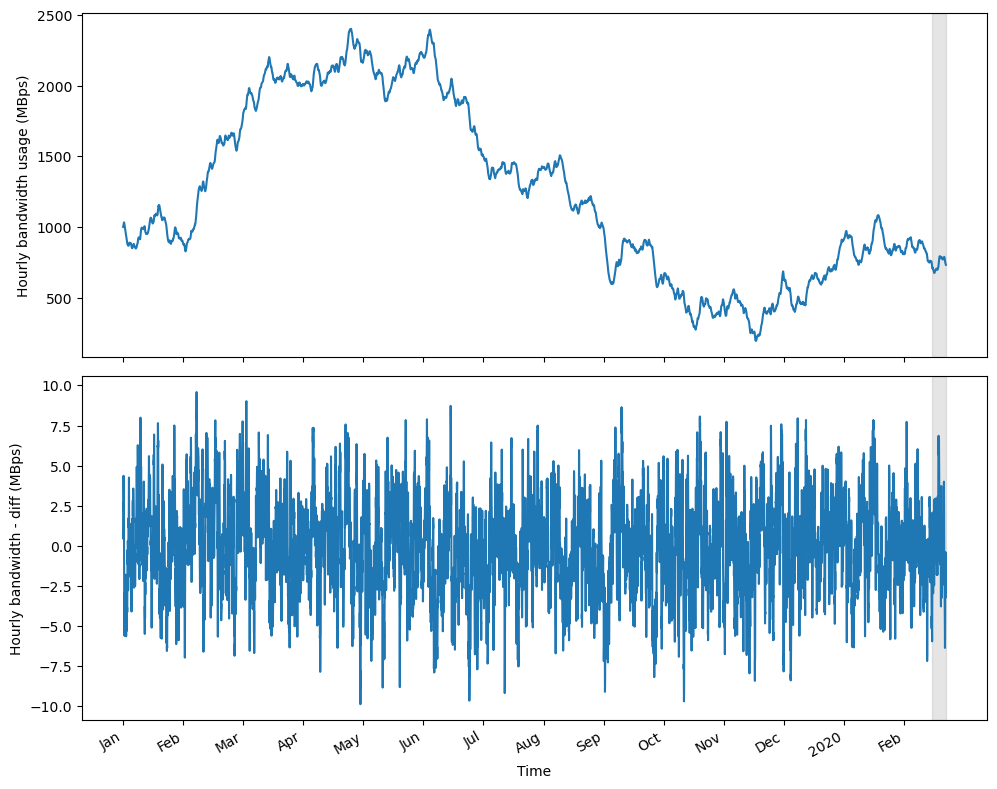

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [41]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [42]:
ps = range(0, 6, 1)
qs = range(0, 6, 1)

order_list = list(product(ps, qs))

In [43]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/36 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(1, 5)",27992.308567
4,"(4, 2)",27992.485191
5,"(2, 4)",27992.945246
6,"(3, 3)",27993.416924
7,"(5, 2)",27993.440266
8,"(1, 4)",27993.460033
9,"(4, 3)",27994.351558


In [44]:
# The ARMA(2,2) model is the model that should be selected. Its AIC value is very
# close to the ARMA(3,2) and ARMA(2,3) models, while being less complex, since it has
# four parameters to be estimated instead of five.

model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Fri, 19 Sep 2025   AIC                          27991.604
Time:                        14:09:47   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

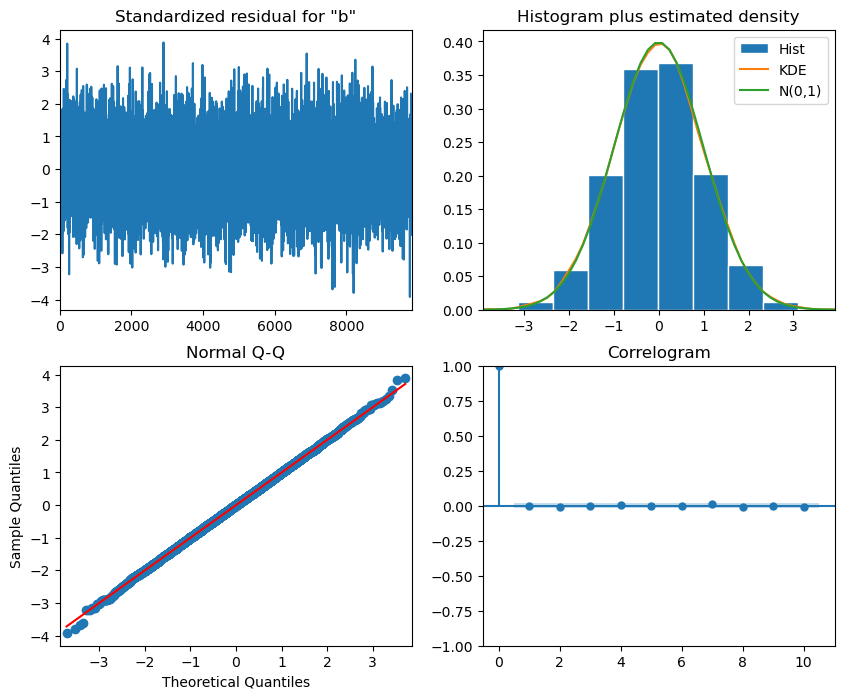

In [45]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [46]:
residuals = model_fit.resid

lb_results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))
# input the residuals as well as a list of lags.

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1     0.042190
2     0.418364
3     0.520271
4     0.850554
5     0.850841
6     1.111754
7     2.124864
8     3.230558
9     3.248662
10    3.588289
Name: lb_stat, dtype: float64

P-values:
1     0.837257
2     0.811247
3     0.914416
4     0.931545
5     0.973678
6     0.981019
7     0.952607
8     0.919067
9     0.953615
10    0.964015
Name: lb_pvalue, dtype: float64


# Forecasting bandwidth usage

In [47]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [48]:
# Because we have an ARMA(2,2) model, meaning that there is an MA(2) component. We know from
# chapter 4 that predicting beyond q steps into the future with an MA(q) model will simply 
# return the mean, so the predictions will remain flat

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


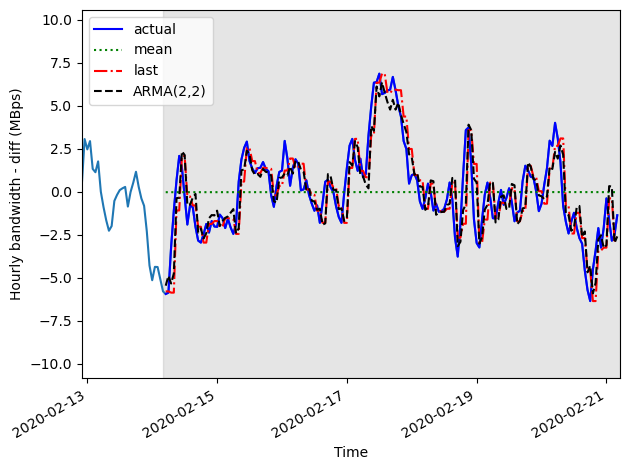

In [49]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [50]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462114421142


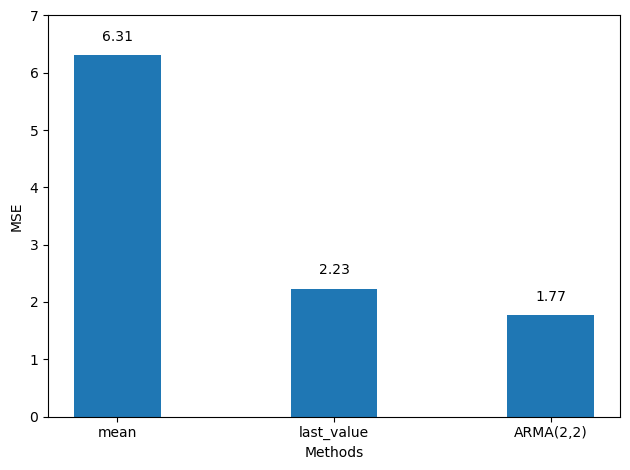

In [51]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [52]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

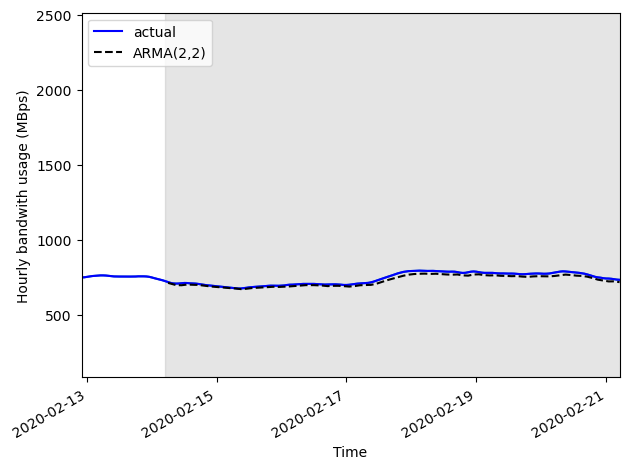

In [53]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [54]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362772514459


# Exercises

## Make predictions on the simulated ARMA(1,1) process

In [55]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [56]:
df = pd.DataFrame({'value': ARMA_1_1})

train = df[:800]
test = df[800:]

In [57]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [58]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


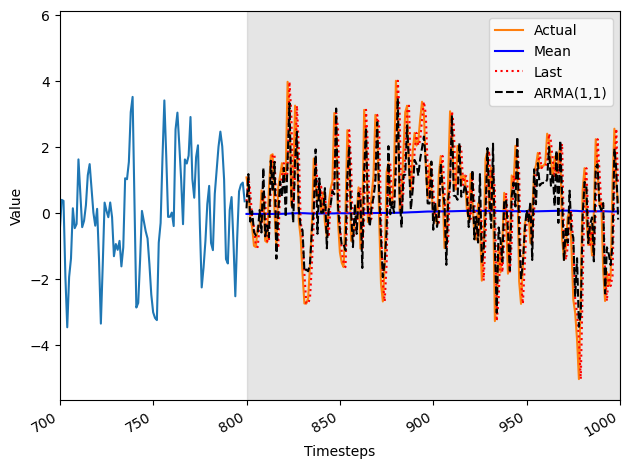

In [59]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(1,1)')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [60]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

2.6792528451659092 1.6761458178498734 0.9281958689671612


## Simulate an ARMA(2,2) process and make forecasts

In [61]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, -0.33, -0.50])

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

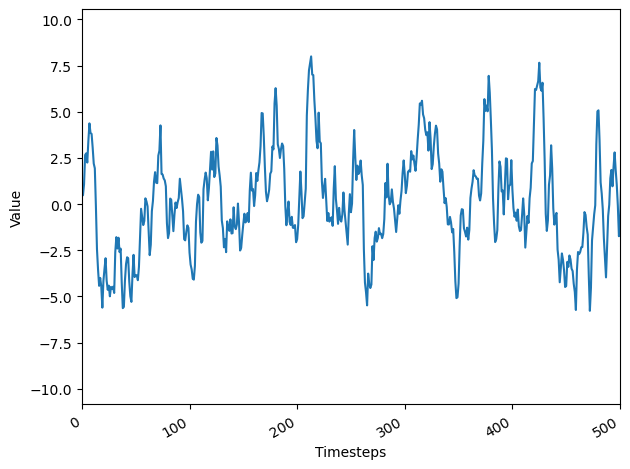

In [62]:
fig, ax = plt.subplots()

ax.plot(ARMA_2_2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [63]:
ADF_result = adfuller(ARMA_2_2)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.684894435243287
p-value: 0.0


In [64]:
df = pd.DataFrame({'value': ARMA_2_2})

train = df[:-200]
test = df[-200:]

print(len(train))

9800


In [65]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [66]:
ps = range(1, 4, 1)
qs = range(1, 4, 1)

order_list = list(product(ps, qs))

In [67]:
result_df = optimize_ARMA(train['value'], order_list)
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27905.101691
1,"(2, 3)",27905.310112
2,"(2, 2)",27905.573367
3,"(3, 3)",27907.356959
4,"(1, 3)",27917.375642
5,"(1, 2)",27965.143311
6,"(3, 1)",27984.569852
7,"(2, 1)",28010.581548
8,"(1, 1)",28085.205818


In [68]:
model = SARIMAX(train['value'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 9800
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13947.787
Date:                Fri, 19 Sep 2025   AIC                          27905.573
Time:                        14:48:07   BIC                          27941.524
Sample:                             0   HQIC                         27917.755
                               - 9800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3470      0.052      6.721      0.000       0.246       0.448
ar.L2          0.4757      0.048     10.010      0.000       0.383       0.569
ma.L1          0.8683      0.050     17.244      0.0

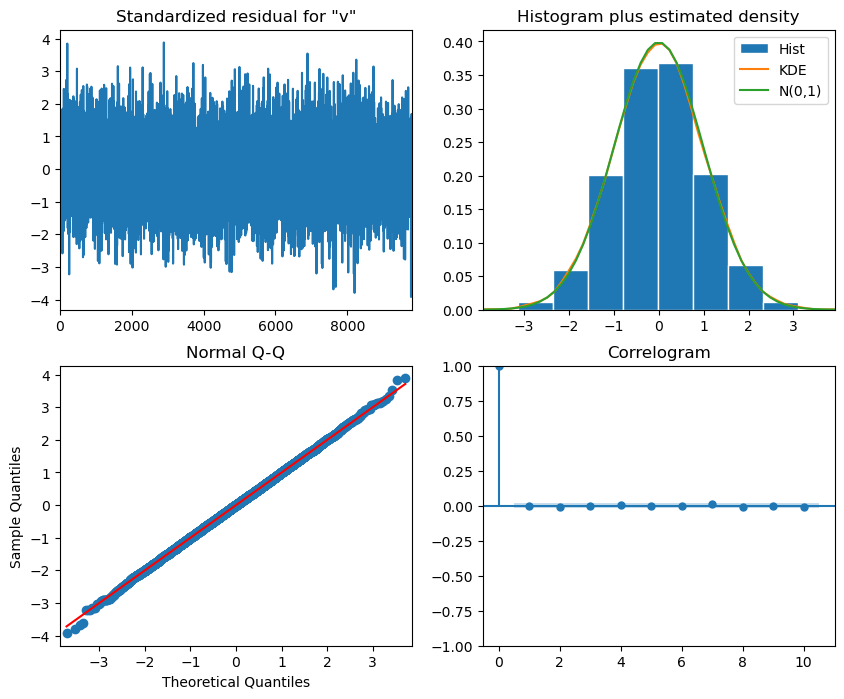

In [69]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [70]:
residuals = model_fit.resid

lb_results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))
# input the residuals as well as a list of lags.

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1     0.042296
2     0.414491
3     0.514013
4     0.819529
5     0.819685
6     1.075739
7     2.077897
8     3.083728
9     3.102822
10    3.415384
Name: lb_stat, dtype: float64

P-values:
1     0.837056
2     0.812820
3     0.915802
4     0.935811
5     0.975761
6     0.982577
7     0.955403
8     0.928994
9     0.960078
10    0.969894
Name: lb_pvalue, dtype: float64


In [71]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [72]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


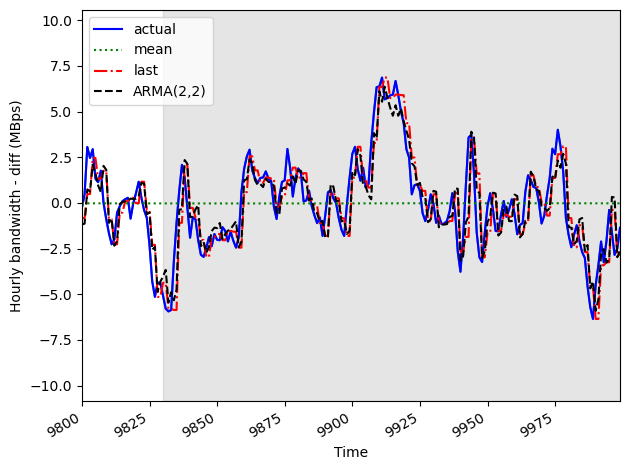

In [73]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

fig.autofmt_xdate()
plt.tight_layout()

In [74]:
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.263912001945173 2.1552606973982593 1.759849420563042


In [ ]:
# Summary

# The autoregressive moving average model, denoted as ARMA(p,q), is the combination 
# of the autoregressive model AR(p) and the moving average model MA(q). 

# An ARMA(p,q) process will display a decaying pattern or a sinusoidal pattern on
# both the ACF and PACF plots. Therefore, they cannot be used to estimate the
# orders p and q.

# The general modeling procedure does not rely on the ACF and PACF plots.
# Instead, we fit many ARMA(p,q) models and perform model selection and
# residual analysis.

# Model selection is done with the Akaike information criterion (AIC). It quantifies 
# the information loss of a model, and it is related to the number of parameters 
# in a model and its goodness of fit. The lower the AIC, the better the model.

# The AIC is relative measure of quality. It returns the best model among other
# models. For an absolute measure of quality, we perform residual analysis.

# Residuals of a good model must approximate white noise, meaning that they
# must be uncorrelated, normally distributed, and independent.

# The Q-Q plot is a graphical tool for comparing two distributions. We use it to
# compare the distribution of the residuals against a theoretical normal distribution.
# If the plot shows a straight line that lies on y = x, then both distributions are similar. 
# Otherwise, it means that the residuals are not normally distributed.
    
# The Ljung-Box test allows us to determine whether the residuals are correlated
# or not. The null hypothesis states that the data is independently distributed
# and uncorrelated. If the returned p-values are larger than 0.05, we cannot
# reject the null hypothesis, meaning that the residuals are uncorrelated, just like white noise.